In [1]:
!pip install timm
!pip install --upgrade sympy

## 235명 테스트 & 평가지표 출력

🚀 [GPU 모드]로 235명 테스트를 시작합니다. (Device: cuda)
📖 매니페스트 로드 및 235명 환자 필터링 중...
✅ 235명 환자의 총 테스트 슬라이스 수: 49,607장
🛠️ 모델 빌드 및 가중치 탑재 중...
🔥 235명 최종 모의고사 채점 시작! (쾌속 스피드)


Testing on GPU: 100%|██████████| 3101/3101 [20:49<00:00,  2.48it/s]


🏆 [Golden Test Set (235명) 최종 점검 결과]
🌟 AUC Score  : 0.5330
✅ Accuracy   : 0.5099
🔥 Recall     : 0.5395
🎯 Precision  : 0.4275
⚖️ F1-Score   : 0.4770


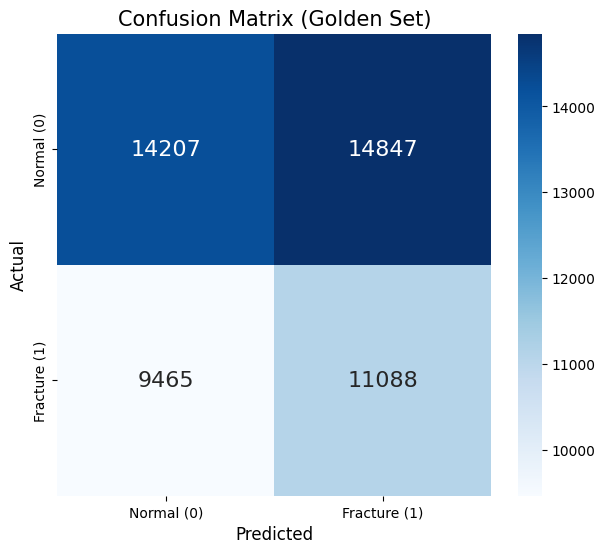

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import timm
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- [시스템 설정] ---
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
cv2.setNumThreads(0) 

# ==========================================
# 1. 설정 및 경로 (GPU 모드 복구)
# ==========================================
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection',
    
    # 3채널 매니페스트
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\old_train\det_train_manifest_2019_3ch.csv',
    
    # 235명 Golden Box CSV
    'golden_bbox_csv': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\filtered_train_bounding_boxes.csv',
    
    # 평가할 가중치 경로 (사용자님 경로 유지)
    'model_weight_path': r'./runs/rsna_clf_efficientnet_pseudo_2019/best_efficientnet_pseudo_20192.pth',
    
    'model_name': 'tf_efficientnetv2_s.in21k_ft_in1k',
    'img_size': 512,
    'batch_size': 16, 
    
    # 🚀 GPU 사용!
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# 평가용 증강
val_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ==========================================
# 2. 데이터셋 (3채널 정적 로딩)
# ==========================================
class RSNAClfDataset(Dataset):
    def __init__(self, df, base_dir, transforms=None):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        full_path = os.path.join(self.base_dir, 'old_train', row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32) 
        except:
            img = np.zeros((3, 512, 512), dtype=np.float32)

        # CLAHE 적용
        img_uint8 = (img * 255).astype(np.uint8)
        channels = [self.clahe.apply(img_uint8[i]) for i in range(3)]
        
        # HWC 결합
        img_hwc = np.stack(channels, axis=-1) 
        
        if self.transforms:
            img_tensor = self.transforms(image=img_hwc)['image']
        else:
            img_tensor = torch.from_numpy(np.transpose(img_hwc, (2,0,1))).float() / 255.0

        label = torch.tensor([float(row['fracture'])], dtype=torch.float32)
        return img_tensor, label

# ==========================================
# 3. 모델 빌드 및 평가 (GPU 실행)
# ==========================================
def run_golden_test_gpu():
    print(f"🚀 [GPU 모드]로 235명 테스트를 시작합니다. (Device: {CONFIG['device']})")
    
    print(f"📖 매니페스트 로드 및 235명 환자 필터링 중...")
    df_full = pd.read_csv(CONFIG['manifest_path'])
    df_golden = pd.read_csv(CONFIG['golden_bbox_csv'])
    
    # 235명 추출
    golden_uids = set(df_golden['StudyInstanceUID'].astype(str).unique())
    df_full['StudyInstanceUID'] = df_full['StudyInstanceUID'].astype(str)
    
    test_df = df_full[df_full['StudyInstanceUID'].isin(golden_uids)].reset_index(drop=True)
    print(f"✅ 235명 환자의 총 테스트 슬라이스 수: {len(test_df):,}장")
    
    # 3채널 Dataset 사용
    test_ds = RSNAClfDataset(test_df, CONFIG['base_dir'], transforms=val_transforms)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
    
    print(f"🛠️ 모델 빌드 및 가중치 탑재 중...")
    model = timm.create_model(CONFIG['model_name'], pretrained=False, in_chans=3, num_classes=1)
    
    if not os.path.exists(CONFIG['model_weight_path']):
        print(f"\n❌ 모델 가중치 파일이 아직 생성되지 않았습니다!\n경로: {CONFIG['model_weight_path']}")
        return
        
    # 🚀 모델과 가중치를 GPU로!
    model.load_state_dict(torch.load(CONFIG['model_weight_path'], map_location=CONFIG['device']))
    model.to(CONFIG['device'])
    model.eval()
    
    all_preds, all_targets = [], []
    
    print("🔥 235명 최종 모의고사 채점 시작! (쾌속 스피드)")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing on GPU"):
            images = images.to(CONFIG['device']) # 데이터를 GPU로
            outputs = model(images)
            
            # GPU에 있는 텐서를 numpy로 바꾸려면 반드시 .cpu()를 먼저 거쳐야 합니다!
            probs = torch.sigmoid(outputs).cpu().numpy().flatten() 
            all_preds.extend(probs)
            all_targets.extend(labels.numpy().flatten())
            
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    preds_binary = (all_preds >= 0.5).astype(int)
    
    # --- 평가지표 ---
    try: auc = roc_auc_score(all_targets, all_preds)
    except: auc = 0.5
    acc = accuracy_score(all_targets, preds_binary)
    recall = recall_score(all_targets, preds_binary, zero_division=0)
    precision = precision_score(all_targets, preds_binary, zero_division=0)
    f1 = f1_score(all_targets, preds_binary, zero_division=0)
    
    print("\n" + "="*40)
    print("🏆 [Golden Test Set (235명) 최종 점검 결과]")
    print("="*40)
    print(f"🌟 AUC Score  : {auc:.4f}")
    print(f"✅ Accuracy   : {acc:.4f}")
    print(f"🔥 Recall     : {recall:.4f}")
    print(f"🎯 Precision  : {precision:.4f}")
    print(f"⚖️ F1-Score   : {f1:.4f}")
    print("="*40)
    
    # --- Confusion Matrix ---
    cm = confusion_matrix(all_targets, preds_binary)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal (0)', 'Fracture (1)'], 
                yticklabels=['Normal (0)', 'Fracture (1)'],
                annot_kws={"size": 16})
    plt.title('Confusion Matrix (Golden Set)', fontsize=15)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.show()

if __name__ == '__main__':
    run_golden_test_gpu()

## 1735?명 학습

📦 전체 데이터 환자 수: 2019명
🛡️ 테스트용으로 제외된 환자 수 (Golden): 235명
🚀 학습/검증에 사용할 환자 수: 1784명

⚖️ [데이터 분할 완료]
  - Train (1:1 밸런스): 85260장 (골절 42630 / 정상 42630)
  - Val (실제 비율 유지): 82868장 (골절 8957 / 정상 73911)
🛠️ 모델 빌드 중: tf_efficientnetv2_s.in21k_ft_in1k


C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()



🚀 [Classification Mode] 1784명 환자 거대 학습 시작! (Model: tf_efficientnetv2_s.in21k_ft_in1k)

[Epoch 1/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.9764 | 📈 Val Loss: 0.7586
🏆 AUC: 0.6606 | Acc: 0.5554 | 🔥 Recall: 0.6833 | 🎯 Prec: 0.1525 | ⚖️ F1: 0.2494
💾 Best Model 저장됨! (AUC: 0.6606) - 카운터 초기화 🔄

[Epoch 2/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.6582 | 📈 Val Loss: 0.5130
🏆 AUC: 0.6679 | Acc: 0.7421 | 🔥 Recall: 0.4100 | 🎯 Prec: 0.1858 | ⚖️ F1: 0.2557
💾 Best Model 저장됨! (AUC: 0.6679) - 카운터 초기화 🔄

[Epoch 3/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.5460 | 📈 Val Loss: 0.6509
🏆 AUC: 0.6621 | Acc: 0.6846 | 🔥 Recall: 0.5194 | 🎯 Prec: 0.1757 | ⚖️ F1: 0.2625
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 1/10)

[Epoch 4/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.4475 | 📈 Val Loss: 0.6769
🏆 AUC: 0.6399 | Acc: 0.7369 | 🔥 Recall: 0.3885 | 🎯 Prec: 0.1757 | ⚖️ F1: 0.2420
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 2/10)

[Epoch 5/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.3655 | 📈 Val Loss: 0.6487
🏆 AUC: 0.6434 | Acc: 0.7645 | 🔥 Recall: 0.3633 | 🎯 Prec: 0.1907 | ⚖️ F1: 0.2501
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 3/10)

[Epoch 6/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.3019 | 📈 Val Loss: 0.7371
🏆 AUC: 0.6313 | Acc: 0.7699 | 🔥 Recall: 0.3381 | 🎯 Prec: 0.1873 | ⚖️ F1: 0.2410
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 4/10)

[Epoch 7/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.2532 | 📈 Val Loss: 0.8068
🏆 AUC: 0.6337 | Acc: 0.7559 | 🔥 Recall: 0.3515 | 🎯 Prec: 0.1792 | ⚖️ F1: 0.2374
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 5/10)

[Epoch 8/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.2159 | 📈 Val Loss: 0.8219
🏆 AUC: 0.6290 | Acc: 0.7575 | 🔥 Recall: 0.3311 | 🎯 Prec: 0.1737 | ⚖️ F1: 0.2279
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 6/10)

[Epoch 9/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.1883 | 📈 Val Loss: 0.8820
🏆 AUC: 0.6193 | Acc: 0.7694 | 🔥 Recall: 0.2985 | 🎯 Prec: 0.1725 | ⚖️ F1: 0.2186
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 7/10)

[Epoch 10/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.1668 | 📈 Val Loss: 0.9525
🏆 AUC: 0.6316 | Acc: 0.7891 | 🔥 Recall: 0.2912 | 🎯 Prec: 0.1899 | ⚖️ F1: 0.2299
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 8/10)

[Epoch 11/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


📉 Train Loss: 0.1437 | 📈 Val Loss: 1.0150
🏆 AUC: 0.6227 | Acc: 0.7847 | 🔥 Recall: 0.2818 | 🎯 Prec: 0.1812 | ⚖️ F1: 0.2206
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 9/10)

[Epoch 12/50]


Training:   0%|          | 0/5329 [00:00<?, ?it/s]C:\Users\smc\AppData\Local\Temp\ipykernel_13232\2572960130.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


📉 Train Loss: 0.1319 | 📈 Val Loss: 0.9407
🏆 AUC: 0.6396 | Acc: 0.8200 | 🔥 Recall: 0.2346 | 🎯 Prec: 0.2067 | ⚖️ F1: 0.2198
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 10/10)

🚨 10 에폭 동안 성능 향상이 없어 학습을 조기 종료(Early Stopping) 합니다!

✨ 거대 데이터 훈련 완료! 최고 AUC: 0.6679
📈 그래프 이미지 저장 완료: ./runs/rsna_clf_efficientnet_pseudo_2019\learning_curve_pseudo_2019.png


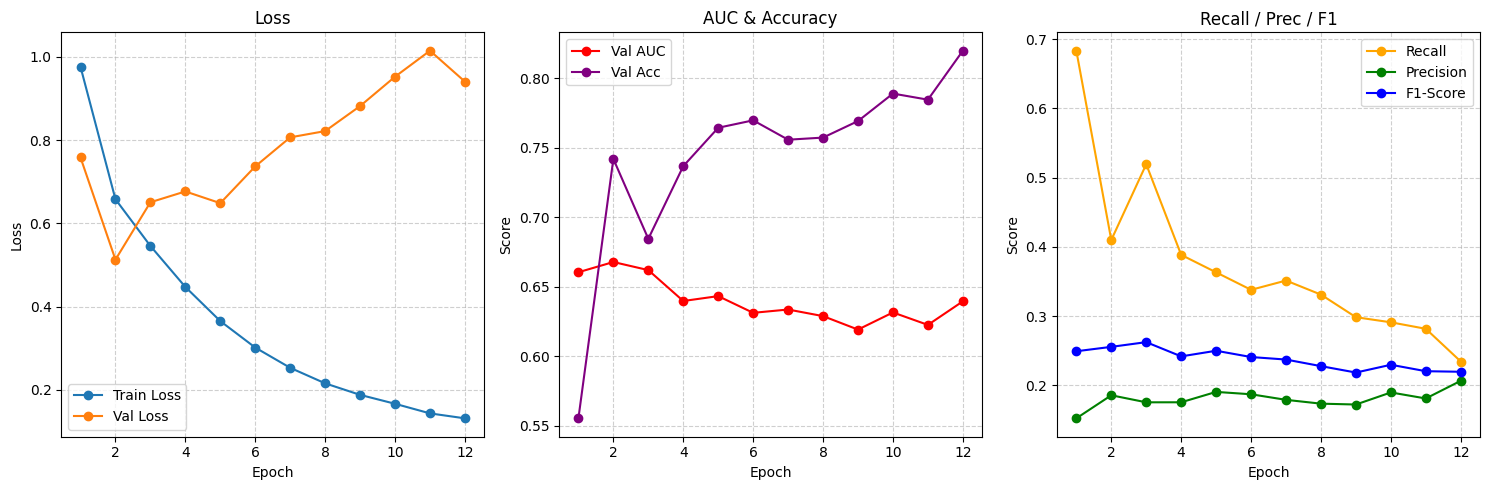

In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import timm  
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GroupShuffleSplit
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt 
import torch.cuda.amp as amp  # 🔥 AMP 라이브러리 추가
torch.backends.cudnn.benchmark = True # 🔥 cuDNN 자동 최적화 치트키 켜기

# --- [1. 시스템 에러 및 멈춤 방지] ---
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
cv2.setNumThreads(0) 

# ==========================================
# 2. 설정 (Configuration)
# ==========================================
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection',
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\old_train\det_train_manifest_2019_3ch.csv',
    
    # 🛡️ 235명 격리용 Golden Box CSV
    'golden_bbox_csv': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\filtered_train_bounding_boxes.csv',
    
    'model_name': 'tf_efficientnetv2_s.in21k_ft_in1k', 
    'img_size': 512,    
    'batch_size': 16,   
    'epochs': 50,
    'patience': 10,       
    'learning_rate': 5e-5, 
    'weight_decay': 5e-2,  
    
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'save_dir': './runs/rsna_clf_efficientnet_pseudo_2019'
}

# ==========================================
# 3. 데이터 증강 (Albumentations) - 의료 영상 최적화 (최신 버전 반영)
# ==========================================
train_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.HorizontalFlip(p=0.5), 
    # ShiftScaleRotate 대신 최신 함수인 Affine 사용
    A.Affine(scale=(0.95, 1.05), translate_percent=(-0.05, 0.05), rotate=(-5, 5), p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5), 
    # GaussNoise의 옛날 파라미터(var_limit) 제거하고 기본값 사용
    A.GaussNoise(p=0.2), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ==========================================
# 4. 데이터셋 (초고속 정적 3채널 로딩)
# ==========================================
class RSNAClfDataset(Dataset):
    def __init__(self, df, base_dir, transforms=None):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 'old_train' 폴더 안의 'detection_cropped_2019_512_3ch' 경로를 정확히 잡아줍니다.
        full_path = os.path.join(self.base_dir, 'old_train', row['file_path'])
        
        # 1. 만들어둔 3채널 npz 단숨에 로드!
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32) # Shape: (3, 512, 512)
        except:
            img = np.zeros((3, 512, 512), dtype=np.float32)

        # 2. 각 채널별로 CLAHE (명암 대비 극대화) 적용
        img_uint8 = (img * 255).astype(np.uint8)
        channels = []
        for i in range(3):
            channels.append(self.clahe.apply(img_uint8[i]))
        
        # 3. Albumentations 증강을 위해 HWC 형태로 결합
        img_hwc = np.stack(channels, axis=-1) 
        
        if self.transforms:
            augmented = self.transforms(image=img_hwc)
            img_tensor = augmented['image']
        else:
            img_tensor = torch.from_numpy(np.transpose(img_hwc, (2,0,1))).float() / 255.0

        label = torch.tensor([float(row['fracture'])], dtype=torch.float32)
        return img_tensor, label

# ==========================================
# 5. 모델 구성
# ==========================================
def build_model(model_name, pretrained=True):
    print(f"🛠️ 모델 빌드 중: {model_name}")
    model = timm.create_model(
        model_name, pretrained=pretrained, in_chans=3, num_classes=1,
        drop_rate=0.3, drop_path_rate=0.2 
    )
    return model

# ==========================================
# 6. 학습 및 검증 함수
# ==========================================
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    # 🔥 AMP 스케일러 준비
    scaler = amp.GradScaler() 
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # 🔥 AMP 마법의 구간 (이 안에서 일어나는 계산은 2배 빨라짐)
        with torch.amp.autocast('cuda'):  # 👈 요렇게 'cuda'를 명시하는 최신 문법으로 변경!
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # 🔥 기존 loss.backward() 대신 스케일러 사용
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
    return running_loss / len(dataloader)

@torch.no_grad()
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    pbar = tqdm(dataloader, desc="Validating", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        probs = torch.sigmoid(outputs).cpu().numpy()
        targets = labels.cpu().numpy()
        
        all_preds.extend(probs)
        all_targets.extend(targets)
        
    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets).flatten()
    preds_binary = (all_preds >= 0.5).astype(int)
    
    val_loss = running_loss / len(dataloader)
    
    try: auc = roc_auc_score(all_targets, all_preds)
    except: auc = 0.5 
    
    acc = accuracy_score(all_targets, preds_binary)
    recall = recall_score(all_targets, preds_binary, zero_division=0)
    precision = precision_score(all_targets, preds_binary, zero_division=0)
    f1 = f1_score(all_targets, preds_binary, zero_division=0)
    
    return val_loss, auc, acc, recall, precision, f1

# ==========================================
# 7. 메인 실행 
# ==========================================
if __name__ == '__main__':
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    
    # 1. 매니페스트 로드
    df_full = pd.read_csv(CONFIG['manifest_path'])
    
    # 2. 🛡️ 235명(Golden Test Set) 완벽 격리!
    df_golden = pd.read_csv(CONFIG['golden_bbox_csv'])
    golden_uids = set(df_golden['StudyInstanceUID'].astype(str).unique())
    df_full['StudyInstanceUID'] = df_full['StudyInstanceUID'].astype(str)
    
    df_train_val = df_full[~df_full['StudyInstanceUID'].isin(golden_uids)].reset_index(drop=True)
    
    print(f"📦 전체 데이터 환자 수: {df_full['StudyInstanceUID'].nunique()}명")
    print(f"🛡️ 테스트용으로 제외된 환자 수 (Golden): {len(golden_uids)}명")
    print(f"🚀 학습/검증에 사용할 환자 수: {df_train_val['StudyInstanceUID'].nunique()}명")

    # 3. 환자 단위로 8:2 스플릿 
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(gss.split(df_train_val, groups=df_train_val['StudyInstanceUID']))
    
    train_df = df_train_val.iloc[train_idx].reset_index(drop=True)
    val_df = df_train_val.iloc[val_idx].reset_index(drop=True)
    
    # 4. ⚖️ Train 데이터 1:1 강제 언더샘플링!
    pos_df = train_df[train_df['fracture'] == 1]
    neg_df = train_df[train_df['fracture'] == 0]
    
    if len(neg_df) > len(pos_df):
        neg_sampled = neg_df.sample(n=len(pos_df), random_state=42)
    else:
        neg_sampled = neg_df
        
    train_df_balanced = pd.concat([pos_df, neg_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    print("\n⚖️ [데이터 분할 완료]")
    print(f"  - Train (1:1 밸런스): {len(train_df_balanced)}장 (골절 {len(pos_df)} / 정상 {len(neg_sampled)})")
    print(f"  - Val (실제 비율 유지): {len(val_df)}장 (골절 {len(val_df[val_df['fracture']==1])} / 정상 {len(val_df[val_df['fracture']==0])})")

    # 5. Dataset 및 DataLoader 준비
    train_ds = RSNAClfDataset(train_df_balanced, CONFIG['base_dir'], transforms=train_transforms)
    val_ds = RSNAClfDataset(val_df, CONFIG['base_dir'], transforms=val_transforms)
    
    train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
    
    device = CONFIG['device']
    model = build_model(CONFIG['model_name']).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])
    
    best_auc = 0.0
    early_stop_counter = 0 
    
    history = {
        'epoch': [], 'train_loss': [], 'val_loss': [], 
        'val_auc': [], 'val_acc': [], 'val_recall': [],
        'val_precision': [], 'val_f1': []
    }
    
    print(f"\n🚀 [Classification Mode] 1784명 환자 거대 학습 시작! (Model: {CONFIG['model_name']})")
    
    for epoch in range(1, CONFIG['epochs'] + 1):
        print(f"\n[Epoch {epoch}/{CONFIG['epochs']}]")
        
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_auc, val_acc, val_recall, val_precision, val_f1 = validate(model, val_loader, criterion, device)
        
        scheduler.step() 
        
        print(f"📉 Train Loss: {train_loss:.4f} | 📈 Val Loss: {val_loss:.4f}")
        print(f"🏆 AUC: {val_auc:.4f} | Acc: {val_acc:.4f} | 🔥 Recall: {val_recall:.4f} | 🎯 Prec: {val_precision:.4f} | ⚖️ F1: {val_f1:.4f}")
        
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_acc'].append(val_acc)
        history['val_recall'].append(val_recall)
        history['val_precision'].append(val_precision)
        history['val_f1'].append(val_f1)

        # ==========================================================
        # 🔥 [여기 추가!] 매 에폭마다 즉시 엑셀(CSV) 덮어쓰기 저장 (자동 저장)
        # ==========================================================
        history_df = pd.DataFrame(history)
        csv_path = os.path.join(CONFIG['save_dir'], "history_pseudo_2019.csv")
        history_df.to_csv(csv_path, index=False)
        # ==========================================================
        
        if val_auc > best_auc:
            best_auc = val_auc
            early_stop_counter = 0 
            save_path = os.path.join(CONFIG['save_dir'], "best_efficientnet_pseudo_2019.pth")
            torch.save(model.state_dict(), save_path)
            print(f"💾 Best Model 저장됨! (AUC: {best_auc:.4f}) - 카운터 초기화 🔄")
        else:
            early_stop_counter += 1 
            print(f"⚠️ 기록 갱신 실패... (Early Stopping 카운터: {early_stop_counter}/{CONFIG['patience']})")
            
            if early_stop_counter >= CONFIG['patience']:
                print(f"\n🚨 {CONFIG['patience']} 에폭 동안 성능 향상이 없어 학습을 조기 종료(Early Stopping) 합니다!")
                break 
                
    print(f"\n✨ 거대 데이터 훈련 완료! 최고 AUC: {best_auc:.4f}")
    

    plt.figure(figsize=(15, 5)) 
    
    plt.subplot(1, 3, 1)
    plt.plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['epoch'], history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 3, 2)
    plt.plot(history['epoch'], history['val_auc'], label='Val AUC', marker='o', color='red')
    plt.plot(history['epoch'], history['val_acc'], label='Val Acc', marker='o', color='purple')
    plt.title('AUC & Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 3, 3)
    plt.plot(history['epoch'], history['val_recall'], label='Recall', marker='o', color='orange')
    plt.plot(history['epoch'], history['val_precision'], label='Precision', marker='o', color='green')
    plt.plot(history['epoch'], history['val_f1'], label='F1-Score', marker='o', color='blue')
    plt.title('Recall / Prec / F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plot_path = os.path.join(CONFIG['save_dir'], "learning_curve_pseudo_2019.png")
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300)
    print(f"📈 그래프 이미지 저장 완료: {plot_path}")
    plt.show()

## 235명

🚀 [GPU 모드]로 235명 테스트를 시작합니다. (Device: cuda)
📖 매니페스트 로드 및 235명 환자 필터링 중...
✅ 235명 환자의 총 테스트 슬라이스 수: 49,607장
🛠️ 모델 빌드 및 가중치 탑재 중...
🔥 235명 최종 모의고사 채점 시작! (쾌속 스피드)


Testing on GPU: 100%|██████████| 3101/3101 [21:25<00:00,  2.41it/s]



🏆 [Golden Test Set (235명) 최종 점검 결과]
🌟 AUC Score  : 0.5274
✅ Accuracy   : 0.5539
🔥 Recall     : 0.3376
🎯 Precision  : 0.4490
⚖️ F1-Score   : 0.3854


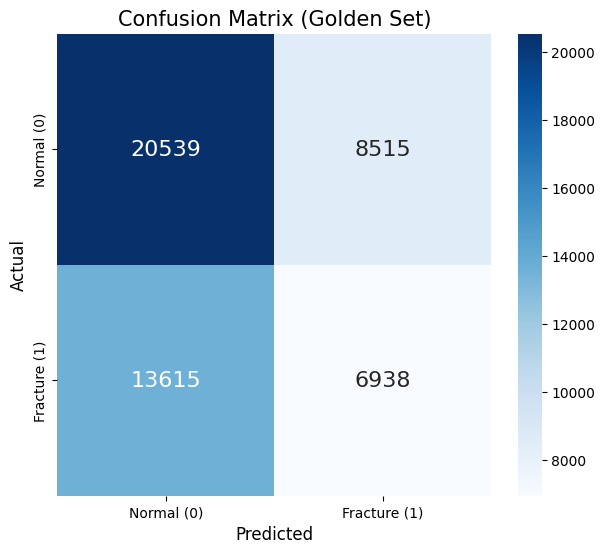

In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import timm
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- [시스템 설정] ---
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
cv2.setNumThreads(0) 

# ==========================================
# 1. 설정 및 경로 (GPU 모드 복구)
# ==========================================
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection',
    
    # 3채널 매니페스트
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\old_train\det_train_manifest_2019_3ch.csv',
    
    # 235명 Golden Box CSV
    'golden_bbox_csv': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\filtered_train_bounding_boxes.csv',
    
    # 평가할 가중치 경로 (사용자님 경로 유지)
    'model_weight_path': r'./runs/rsna_clf_efficientnet_pseudo_2019/best_efficientnet_pseudo_2019.pth',
    
    'model_name': 'tf_efficientnetv2_s.in21k_ft_in1k',
    'img_size': 512,
    'batch_size': 16, 
    
    # 🚀 GPU 사용!
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# 평가용 증강
val_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ==========================================
# 2. 데이터셋 (3채널 정적 로딩)
# ==========================================
class RSNAClfDataset(Dataset):
    def __init__(self, df, base_dir, transforms=None):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        full_path = os.path.join(self.base_dir, 'old_train', row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32) 
        except:
            img = np.zeros((3, 512, 512), dtype=np.float32)

        # CLAHE 적용
        img_uint8 = (img * 255).astype(np.uint8)
        channels = [self.clahe.apply(img_uint8[i]) for i in range(3)]
        
        # HWC 결합
        img_hwc = np.stack(channels, axis=-1) 
        
        if self.transforms:
            img_tensor = self.transforms(image=img_hwc)['image']
        else:
            img_tensor = torch.from_numpy(np.transpose(img_hwc, (2,0,1))).float() / 255.0

        label = torch.tensor([float(row['fracture'])], dtype=torch.float32)
        return img_tensor, label

# ==========================================
# 3. 모델 빌드 및 평가 (GPU 실행)
# ==========================================
def run_golden_test_gpu():
    print(f"🚀 [GPU 모드]로 235명 테스트를 시작합니다. (Device: {CONFIG['device']})")
    
    print(f"📖 매니페스트 로드 및 235명 환자 필터링 중...")
    df_full = pd.read_csv(CONFIG['manifest_path'])
    df_golden = pd.read_csv(CONFIG['golden_bbox_csv'])
    
    # 235명 추출
    golden_uids = set(df_golden['StudyInstanceUID'].astype(str).unique())
    df_full['StudyInstanceUID'] = df_full['StudyInstanceUID'].astype(str)
    
    test_df = df_full[df_full['StudyInstanceUID'].isin(golden_uids)].reset_index(drop=True)
    print(f"✅ 235명 환자의 총 테스트 슬라이스 수: {len(test_df):,}장")
    
    # 3채널 Dataset 사용
    test_ds = RSNAClfDataset(test_df, CONFIG['base_dir'], transforms=val_transforms)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
    
    print(f"🛠️ 모델 빌드 및 가중치 탑재 중...")
    model = timm.create_model(CONFIG['model_name'], pretrained=False, in_chans=3, num_classes=1)
    
    if not os.path.exists(CONFIG['model_weight_path']):
        print(f"\n❌ 모델 가중치 파일이 아직 생성되지 않았습니다!\n경로: {CONFIG['model_weight_path']}")
        return
        
    # 🚀 모델과 가중치를 GPU로!
    model.load_state_dict(torch.load(CONFIG['model_weight_path'], map_location=CONFIG['device']))
    model.to(CONFIG['device'])
    model.eval()
    
    all_preds, all_targets = [], []
    
    print("🔥 235명 최종 모의고사 채점 시작! (쾌속 스피드)")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing on GPU"):
            images = images.to(CONFIG['device']) # 데이터를 GPU로
            outputs = model(images)
            
            # GPU에 있는 텐서를 numpy로 바꾸려면 반드시 .cpu()를 먼저 거쳐야 합니다!
            probs = torch.sigmoid(outputs).cpu().numpy().flatten() 
            all_preds.extend(probs)
            all_targets.extend(labels.numpy().flatten())
            
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    preds_binary = (all_preds >= 0.5).astype(int)
    
    # --- 평가지표 ---
    try: auc = roc_auc_score(all_targets, all_preds)
    except: auc = 0.5
    acc = accuracy_score(all_targets, preds_binary)
    recall = recall_score(all_targets, preds_binary, zero_division=0)
    precision = precision_score(all_targets, preds_binary, zero_division=0)
    f1 = f1_score(all_targets, preds_binary, zero_division=0)
    
    print("\n" + "="*40)
    print("🏆 [Golden Test Set (235명) 최종 점검 결과]")
    print("="*40)
    print(f"🌟 AUC Score  : {auc:.4f}")
    print(f"✅ Accuracy   : {acc:.4f}")
    print(f"🔥 Recall     : {recall:.4f}")
    print(f"🎯 Precision  : {precision:.4f}")
    print(f"⚖️ F1-Score   : {f1:.4f}")
    print("="*40)
    
    # --- Confusion Matrix ---
    cm = confusion_matrix(all_targets, preds_binary)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal (0)', 'Fracture (1)'], 
                yticklabels=['Normal (0)', 'Fracture (1)'],
                annot_kws={"size": 16})
    plt.title('Confusion Matrix (Golden Set)', fontsize=15)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.show()

if __name__ == '__main__':
    run_golden_test_gpu()